In [39]:
import os
import scenic
scenic_script = "./examples/carla/car.scenic"
# scenic_script = "./examples/carla/test2.scenic"
scenario = scenic.scenarioFromFile(scenic_script)

# from scenic.domains.driving.roads import ManeuverType, Network
# map_path = '/Users/edwardkim/Desktop/Scenic-devel/examples/carla/../../tests/formats/opendrive/maps/CARLA/Town05.xodr'
# network = Network.fromFile(map_path)

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/simulators/carla/model.scenic:56: UserWarning: the "carla" package is not installed; will not be able to run dynamic simulations
  warnings.warn('the "carla" package is not installed; '


In [41]:
from scenic.core.vectors import OrientedVector, Vector
import shapely.geometry
import matplotlib.pyplot as plt
from scenic.core.type_support import toVector
from scenic.core.regions import PolygonalRegion, PointInRegionDistribution
import os.path as path

scenario.egoObject.position.region

PolygonalRegion(MULTIPOLYGON (((-277.7396215432509 -19.72184542728575, -277.73961625 -19.721493536, -277.789879238 -14.021495657, -277.789811863 -14.019828754, -277.789822209 -14.015548636, -277.789908708 -14.01363757, -277.753532542 -5.161343029, -277.75352876 -5.16099894, -277.459115348 11.308938747, -277.459108961 11.309432421, -277.3798206120706 21.22080321730841, -277.379810999 21.221101753, -277.119128686 56.843291697, -277.119098815 56.844344036, -276.966696338 59.924619045, -276.966578543 59.92610291, -276.782849118 61.605014248, -276.782627608 61.606579072, -276.203603813 64.93493232500001, -276.20315561 64.93699064, -275.345927174 68.20449463600001, -275.345307203 68.206507888, -274.215920754 71.390202149, -274.21513342 71.392156031, -272.821506078 74.46965611100001, -272.820808933 74.471074466, -272.028270439 75.962458752, -272.027485046 75.96383021, -270.256627486 78.84116380899999, -270.255756986 78.842482887, -269.281412359 80.221974429, -269.280460232 80.223235854, -267.

label.position:  (108.36546447205663 @ 15.2153565224748)
sampled position: 23.76206016361125 -201.16230930976596


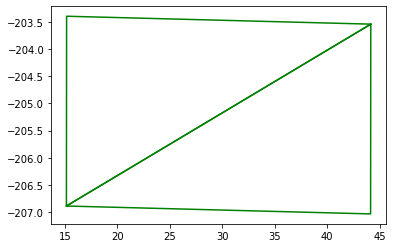

AssertionError: 

In [3]:

from scenic.core.distributions import *
from scenic.core.vectors import Vector
from scenic.core.regions import SectorRegion
import math
import subprocess
import os


# TODO : need to handle jointly dependent objs as well
def isPositionValid(obj, label, smt_file_path, ego_info, debug=False, falseTesting=False):
    
    # TODO : need to handle jointly dependent objs as well
    if os.path.isfile(smt_file_path):
        os.remove(smt_file_path)
    
    open(smt_file_path, 'w').close()
    writeSMTtoFile(smt_file_path, '(set-logic QF_NRA)')

    # Instantiate cached_variables dictionary
    cached_variables = {}
    cached_variables['variables'] = []
    if not falseTesting:
        x = label.position.x
        y = label.position.y
    else:
        x = 23.76206016361125
        y = -201.16230930976596
        
    # Create Ego's VisibleRegion
    cached_variables['current_obj_pos'] = (x, y)
    ego_labelled_position = Vector(x,y)
    print("sampled position: "+ str(x)+" "+ str(y))
    ego_visibleDistance = ego_info['visibleDistance']
    ego_viewAngle = ego_info['viewAngle']
    ego_labelled_heading = ego_info['headingAngle']
    egoVisibleRegion = SectorRegion(ego_labelled_position, ego_visibleDistance, \
                                    ego_labelled_heading, ego_viewAngle)
    cached_variables['egoVisibleRegion'] = egoVisibleRegion.polygon
    
    # Encode object's position to SMT formula
    pos_smt_var = obj.position.encodeToSMT(smt_file_path, cached_variables, debug = debug)

    if pos_smt_var is None:
        print("NOT FEASIBLE POSITION: "+ str(cached_variables['current_obj_pos']))
        return False

    else:
        (x_cond, y_cond) = vector_operation_smt(pos_smt_var, "equal", (str(x), str(y)))
        writeSMTtoFile(smt_file_path, smt_assert(None, x_cond))
        writeSMTtoFile(smt_file_path, smt_assert(None, y_cond))
        writeSMTtoFile(smt_file_path, "(check-sat)")
        writeSMTtoFile(smt_file_path, "(exit)")

        if not debug:
            if subprocess.call("./run_smt_encoding.sh") == 1:
                return True
            else:
                return False
        else:
            print("DEBUG MODE: NO OUTPUT WILL BE RETURNED")
            
    return None


ego_visibleDistance = 100 #meters
ego_viewAngle = 135 #deg
ego_sample = scenario.egoObject.sample()
ego_info = {
    'visibleDistance' : ego_visibleDistance,
    'viewAngle' : math.radians(ego_viewAngle), #radians,
    'headingAngle' : ego_sample.heading #radians
}

smt_file_path = './test_smt_encoding.smt2'
resetConditionedObj(scenario)
obj = scenario.egoObject
label = obj.sample()
print("label.position: ", label.position)
print(isPositionValid(obj, label, smt_file_path, ego_info, debug=True, falseTesting=False))

In [11]:
laneSec = scenario.egoObject.position.object.region.options[0]
scenario.egoObject.position.object.region.conditionTo(laneSec)
pos = scenario.egoObject.position.object.sample()
heading = laneSec._defaultHeadingAt(pos)
import math
print(math.degrees(heading))

90.13946052598955


In [21]:
from scenic.core.vectors import Vector
[x1, y1] = laneSec.centerline.points[0]
[x2, y2] = laneSec.centerline.points[1]
pt1 = Vector(x1, y1)
pt2 = Vector(x2, y2)
math.degrees(pt1.angleTo(pt2))

90.13946052598955

In [38]:
print((scenario.egoObject.position.operands[0].dist.object))

Options(<LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <L